# 摩拜单车用户分群

## 任务说明

这一周我会带着你挑战一个互联网行业比较常见的任务，绘制产品的用户画像。摩拜单车，英文名mobike，是由胡玮炜创办的北京摩拜科技有限公司研发的互联网短途出行解决方案，是无桩借还车模式的智能硬件。人们通过智能手机就能快速租用和归还一辆摩拜单车，用可负担的价格来完成一次几公里的市内骑行。由于一公里的出行是一个高频的需求场景，所以mobike单车累计了大量的用户基本信息以及骑行的数据，通过这些数据，能够帮助企业更好识别自己的客群画像和他们的骑行偏好。

## 任务事项

就是根据用户的基本信息以及骑行的数据，完成以下事项：
- 使用Python建立聚类分析模型
- 对于聚类分析模型得出的分群特征进行解读

## 任务要求

- 完整的数据分析流程（50%）
    - 数据概况分析
    - 单变量分析
    - 相关与可视化分析
    - 聚类模型建立、评估与优化
- 准确的数据维度识别与python代码操作（30%）
- 提供对于模型结果的业务结论解读（20%）

## 认识数据

![jupyter](image.png)

## 数据分析流程

![jupyter](image1.png)

## 数据分析思路

![jupyter](image2.png)

# 数据预处理

## 准备数据

In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [319]:
mb = pd.read_csv('week4.mobike.csv', index_col=0)

In [320]:
mb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6427 entries, 439283 to 278179
Data columns (total 14 columns):
user_id              6427 non-null int64
start_time           6427 non-null object
end_time             6427 non-null object
timeduration         6427 non-null int64
bikeid               6427 non-null int64
tripduration         6427 non-null int64
from_station_id      6427 non-null int64
from_station_name    6427 non-null object
to_station_id        6427 non-null int64
to_station_name      6427 non-null object
usertype             6427 non-null object
gender               5938 non-null object
birthyear            5956 non-null float64
age                  6427 non-null object
dtypes: float64(1), int64(6), object(7)
memory usage: 753.2+ KB


- gender,birthyear有空值
- user_id,bikeid,start_time,end_time,from_station_id,to_station_id,birthyear,age的类型错误，要转换过来
- user_id，bikeid,from_station_id,to_station_id,birthyear,end_time对后续分析没有用，可以删掉


In [321]:
mb.head()

,user_id,start_time,end_time,timeduration,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age
439283,21499218,11/14/2018 7:37,11/14/2018 7:44,7,2631,436,319,Greenview Ave & Diversey Pkwy,67,Sheffield Ave & Fullerton Ave,Subscriber,Male,1982.0,37
603317,21694389,12/18/2018 19:02,12/18/2018 19:10,7,1565,445,164,Franklin St & Lake St,195,Columbus Dr & Randolph St,Subscriber,Male,1988.0,31
109957,21110722,10/9/2018 12:37,10/9/2018 12:55,18,2231,1090,163,Damen Ave & Clybourn Ave,69,Damen Ave & Pierce Ave,Customer,Male,1989.0,30
428082,21485409,11/12/2018 12:30,11/12/2018 12:40,9,4226,581,226,Racine Ave & Belmont Ave,308,Seeley Ave & Roscoe St,Subscriber,Female,1989.0,30
395437,21445994,11/7/2018 7:29,11/7/2018 7:35,6,3475,390,77,Clinton St & Madison St,621,Aberdeen St & Randolph St,Subscriber,Male,1979.0,40


In [322]:
mb.describe()

,user_id,timeduration,bikeid,tripduration,from_station_id,to_station_id,birthyear
count,6.427000e+03,6427.000000,6427.000000,6.427000e+03,6427.000000,6427.000000,5956.000000
mean,2.135519e+07,11.778902,3491.637934,1.060471e+03,195.038432,198.502567,1982.488583
std,2.181294e+05,9.692236,1912.171846,1.456811e+04,148.170025,148.939873,11.147859
min,2.098358e+07,0.000000,2.000000,6.100000e+01,2.000000,2.000000,1906.000000
25%,2.116805e+07,5.000000,1852.000000,3.490000e+02,77.000000,80.000000,1977.000000
50%,2.135114e+07,9.000000,3618.000000,5.590000e+02,168.000000,172.000000,1986.000000
75%,2.154376e+07,15.000000,5179.500000,9.320000e+02,287.000000,287.000000,1991.000000
max,2.174223e+07,59.000000,6470.000000,1.139070e+06,662.000000,661.000000,2002.000000


- timeduration最小值是0，要查看一下是什么原因
- birthyear最小值是1906，不可能

In [323]:
sum(mb.duplicated())

0

## 数据清洗

### user_id

In [324]:
mb.user_id.nunique()

6427

- 数据中不存在重复用户，所以不需要进行聚类，直接删除user_id即可

In [325]:
# 删除user_id列
mb = mb.drop(['user_id'], axis=1)

### start_time&end_time

In [326]:
# start_time和end_time的类型转换为datetime的类型
mb['start_time'] = pd.to_datetime(mb['start_time'])

In [327]:
mb['end_time'] = pd.to_datetime(mb['end_time'])

In [328]:
mb.head()

,start_time,end_time,timeduration,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age
439283,2018-11-14 07:37:00,2018-11-14 07:44:00,7,2631,436,319,Greenview Ave & Diversey Pkwy,67,Sheffield Ave & Fullerton Ave,Subscriber,Male,1982.0,37
603317,2018-12-18 19:02:00,2018-12-18 19:10:00,7,1565,445,164,Franklin St & Lake St,195,Columbus Dr & Randolph St,Subscriber,Male,1988.0,31
109957,2018-10-09 12:37:00,2018-10-09 12:55:00,18,2231,1090,163,Damen Ave & Clybourn Ave,69,Damen Ave & Pierce Ave,Customer,Male,1989.0,30
428082,2018-11-12 12:30:00,2018-11-12 12:40:00,9,4226,581,226,Racine Ave & Belmont Ave,308,Seeley Ave & Roscoe St,Subscriber,Female,1989.0,30
395437,2018-11-07 07:29:00,2018-11-07 07:35:00,6,3475,390,77,Clinton St & Madison St,621,Aberdeen St & Randolph St,Subscriber,Male,1979.0,40


In [329]:
# 提取start_time的dayofweek和hour
mb['dayofweek'] = mb['start_time'].dt.dayofweek
mb['hour'] = mb['start_time'].dt.hour

In [330]:
mb.head()

,start_time,end_time,timeduration,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age,dayofweek,hour
439283,2018-11-14 07:37:00,2018-11-14 07:44:00,7,2631,436,319,Greenview Ave & Diversey Pkwy,67,Sheffield Ave & Fullerton Ave,Subscriber,Male,1982.0,37,2,7
603317,2018-12-18 19:02:00,2018-12-18 19:10:00,7,1565,445,164,Franklin St & Lake St,195,Columbus Dr & Randolph St,Subscriber,Male,1988.0,31,1,19
109957,2018-10-09 12:37:00,2018-10-09 12:55:00,18,2231,1090,163,Damen Ave & Clybourn Ave,69,Damen Ave & Pierce Ave,Customer,Male,1989.0,30,1,12
428082,2018-11-12 12:30:00,2018-11-12 12:40:00,9,4226,581,226,Racine Ave & Belmont Ave,308,Seeley Ave & Roscoe St,Subscriber,Female,1989.0,30,0,12
395437,2018-11-07 07:29:00,2018-11-07 07:35:00,6,3475,390,77,Clinton St & Madison St,621,Aberdeen St & Randolph St,Subscriber,Male,1979.0,40,2,7


### timeduration

In [331]:
# 查看timeduration的问题
mb['timeduration'].describe()

count    6427.000000
mean       11.778902
std         9.692236
min         0.000000
25%         5.000000
50%         9.000000
75%        15.000000
max        59.000000
Name: timeduration, dtype: float64

In [332]:
mb[mb['timeduration']<1]

,start_time,end_time,timeduration,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age,dayofweek,hour
109113,2018-10-09 11:29:00,2018-10-09 12:29:00,0,4875,3616,225,Halsted St & Dickens Ave,172,Rush St & Cedar St,Customer,NaN,NaN,,1,11
72232,2018-10-06 10:15:00,2018-10-06 11:15:00,0,4733,3606,419,Lake Park Ave & 53rd St,76,Lake Shore Dr & Monroe St,Customer,NaN,NaN,,5,10
69595,2018-10-05 18:27:00,2018-10-05 19:28:00,0,2064,3650,50,Clark St & Congress Pkwy,283,LaSalle St & Jackson Blvd,Customer,Male,1989.0,30,4,18
302629,2018-10-27 15:33:00,2018-10-27 16:34:00,0,5051,3634,3,Shedd Aquarium,199,Wabash Ave & Grand Ave,Customer,NaN,NaN,,5,15
592619,2018-12-17 09:17:00,2018-12-17 10:18:00,0,4316,3652,99,Lake Shore Dr & Ohio St,96,Desplaines St & Randolph St,Subscriber,Male,1988.0,31,0,9


- 看start_time和end_time和timeduration,发现用户骑行了1小时，但timeduration却是0，因此把timeduration为0改为60

In [333]:
mb['timeduration'] = mb['timeduration'].replace(0, 60)

In [334]:
mb['timeduration'].describe()

count    6427.000000
mean       11.825580
std         9.779498
min         1.000000
25%         5.000000
50%         9.000000
75%        15.000000
max        60.000000
Name: timeduration, dtype: float64

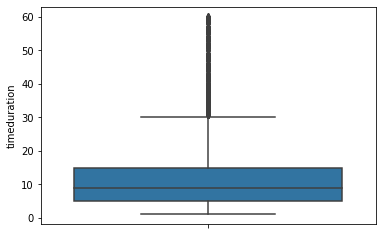

In [335]:
sns.boxplot(y=mb['timeduration'])

- 存在异常值

### tripduration

In [336]:
mb['tripduration'].describe()

count    6.427000e+03
mean     1.060471e+03
std      1.456811e+04
min      6.100000e+01
25%      3.490000e+02
50%      5.590000e+02
75%      9.320000e+02
max      1.139070e+06
Name: tripduration, dtype: float64

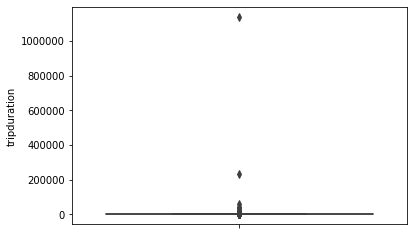

In [337]:
sns.boxplot(y = mb['tripduration'])

- tripduration的标准差太大了，存在异常值

### from_station_id&to_station_id

In [338]:
# from_station_id和to_station_id的类型改为str
mb['from_station_id'] = mb['from_station_id'].astype(str)
mb['to_station_id'] = mb['to_station_id'].astype(str)

### usertype

In [339]:
# 查看usertype是否有大小写拼写不一致
mb['usertype'].unique()

array(['Subscriber', 'Customer'], dtype=object)

### gender

In [340]:
# gender
mb['gender'].unique()

array(['Male', 'Female', nan], dtype=object)

In [341]:
# 把gender的缺失值替换为Unknown
mb['gender'] = mb['gender'].fillna('Unknown')

### age

In [342]:
# birthyear存在缺失值和异常值，但是age可以表示年龄信息，因此可以删除birthyear，保留age,并修改age的数据类型为int
mb['age'] = mb['age'].astype(int)

ValueError: invalid literal for int() with base 10: ' '

In [343]:
mb['age'].unique()

array(['37', '31', '30', '40', '25', '48', ' ', '28', '27', '34', '33',
       '26', '20', '23', '55', '22', '54', '52', '57', '29', '39', '51',
       '32', '49', '43', '58', '42', '61', '35', '41', '63', '50', '38',
       '36', '44', '62', '19', '59', '45', '46', '56', '21', '24', '47',
       '66', '64', '77', '69', '60', '68', '70', '53', '113', '73', '18',
       '67', '65', '71', '79', '17', '101', '74', '72'], dtype=object)

- age有空格，可以考虑birthyear去补充空格

In [344]:
mb[mb['age']==' ']

,start_time,end_time,timeduration,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age,dayofweek,hour
371796,2018-11-03 16:32:00,2018-11-03 16:54:00,22,983,1347,31,Franklin St & Chicago Ave,315,Elston Ave & Wabansia Ave,Customer,Unknown,NaN,,5,16
80060,2018-10-07 07:31:00,2018-10-07 12:02:00,31,3552,16274,196,Cityfront Plaza Dr & Pioneer Ct,45,Michigan Ave & Congress Pkwy,Customer,Unknown,NaN,,6,7
92242,2018-10-08 12:10:00,2018-10-08 12:18:00,7,1582,453,341,Adler Planetarium,3,Shedd Aquarium,Customer,Unknown,NaN,,0,12
331956,2018-10-30 18:42:00,2018-10-30 18:59:00,17,6267,1056,128,Damen Ave & Chicago Ave,342,Wolcott Ave & Polk St,Customer,Unknown,NaN,,1,18
208326,2018-10-18 10:52:00,2018-10-18 11:17:00,24,4129,1465,97,Field Museum,35,Streeter Dr & Grand Ave,Customer,Unknown,NaN,,3,10
26662,2018-10-02 18:01:00,2018-10-02 18:32:00,30,4866,1851,188,Greenview Ave & Fullerton Ave,87,Racine Ave & Fullerton Ave,Customer,Unknown,NaN,,1,18
46950,2018-10-04 00:41:00,2018-10-04 00:57:00,15,5393,956,31,Franklin St & Chicago Ave,181,LaSalle St & Illinois St,Customer,Unknown,NaN,,3,0
245767,2018-10-22 16:08:00,2018-10-22 16:38:00,30,2052,1815,268,Lake Shore Dr & North Blvd,35,Streeter Dr & Grand Ave,Customer,Unknown,NaN,,0,16
355308,2018-11-01 20:26:00,2018-11-01 20:30:00,4,3718,265,114,Sheffield Ave & Waveland Ave,229,Southport Ave & Roscoe St,Customer,Unknown,NaN,,3,20
459268,2018-11-17 03:34:00,2018-11-17 04:08:00,33,5867,2016,40,LaSalle St & Adams St,33,State St & Van Buren St,Customer,Unknown,NaN,,5,3


- 发现他们的birthyear也是空值

In [345]:
(mb[mb['age'] == ' '].index == mb[mb['birthyear'].isna()].index).all()

True

- 发现age为空格的样本中birthyear均为缺失，且位置完全一致

In [346]:
# 用非空格的age的中位数去填充空格
age_median = int(mb[mb['age'] != ' ']['age'].astype(int).median())
age_median

33

In [348]:
mb['age'] = mb['age'].str.replace(' ', str(age_median)).astype(int)

In [349]:
# age转换为int类型
mb['age'] = mb['age'].astype(int)

In [ ]:
mb['age'].describe()

- 发现age最大值是113，明显是异常值

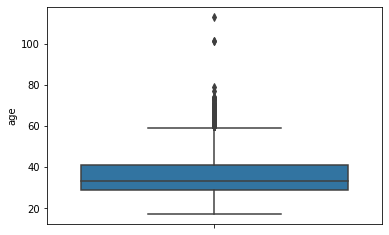

In [350]:
sns.boxplot(y=mb['age'])

In [351]:
mb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6427 entries, 439283 to 278179
Data columns (total 15 columns):
start_time           6427 non-null datetime64[ns]
end_time             6427 non-null datetime64[ns]
timeduration         6427 non-null int64
bikeid               6427 non-null int64
tripduration         6427 non-null int64
from_station_id      6427 non-null object
from_station_name    6427 non-null object
to_station_id        6427 non-null object
to_station_name      6427 non-null object
usertype             6427 non-null object
gender               6427 non-null object
birthyear            5956 non-null float64
age                  6427 non-null int32
dayofweek            6427 non-null int64
hour                 6427 non-null int64
dtypes: datetime64[ns](2), float64(1), int32(1), int64(5), object(6)
memory usage: 778.3+ KB


### 删除无关变量

In [352]:
# 删除无关变量，from_station_id,to_station_id,birthyear,start_time,end_time
delete_feature = ['bikeid','from_station_id','to_station_id','birthyear','start_time', 'end_time']
mb = mb.drop(delete_feature, axis=1)
mb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6427 entries, 439283 to 278179
Data columns (total 9 columns):
timeduration         6427 non-null int64
tripduration         6427 non-null int64
from_station_name    6427 non-null object
to_station_name      6427 non-null object
usertype             6427 non-null object
gender               6427 non-null object
age                  6427 non-null int32
dayofweek            6427 non-null int64
hour                 6427 non-null int64
dtypes: int32(1), int64(4), object(4)
memory usage: 477.0+ KB


### 异常值处理

In [353]:
# newmax=75%+四分位差*1.5
newmax = mb['tripduration'].describe()['75%'] + 1.5*(mb['tripduration'].describe()['75%'] - mb['tripduration'].describe()['25%'])
newmax

1806.5

In [354]:
mb = mb[mb['tripduration']<=newmax]

In [355]:
newmax = mb['age'].describe()['75%'] + 1.5*(mb['age'].describe()['75%'] - mb['age'].describe()['25%'])
newmax

63.0

In [356]:
mb = mb[mb['age']<=newmax]

# EDA

In [357]:
mb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5853 entries, 439283 to 278179
Data columns (total 9 columns):
timeduration         5853 non-null int64
tripduration         5853 non-null int64
from_station_name    5853 non-null object
to_station_name      5853 non-null object
usertype             5853 non-null object
gender               5853 non-null object
age                  5853 non-null int32
dayofweek            5853 non-null int64
hour                 5853 non-null int64
dtypes: int32(1), int64(4), object(4)
memory usage: 434.4+ KB


- 数值型变量有：timeduration,tripduration,age,dayofweek,hour
- 类别变量有：from_station_name,to_station_name,usertype,gender

## 单变量探索

### 数值型变量

#### timeduration的分布

In [358]:
mb['timeduration'].describe()

count    5853.000000
mean        9.934393
std         6.339840
min         1.000000
25%         5.000000
50%         8.000000
75%        13.000000
max        30.000000
Name: timeduration, dtype: float64

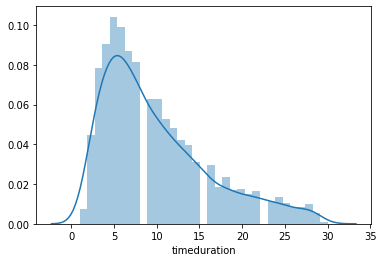

In [359]:
sns.distplot(mb['timeduration'])

- timeduration主要分布在1-30分钟之间
- 大部分人的骑行时间在10分钟以内

#### tripduration的分布

In [360]:
mb['tripduration'].describe()

count    5853.000000
mean      625.527593
std       380.226556
min        61.000000
25%       336.000000
50%       521.000000
75%       828.000000
max      1805.000000
Name: tripduration, dtype: float64

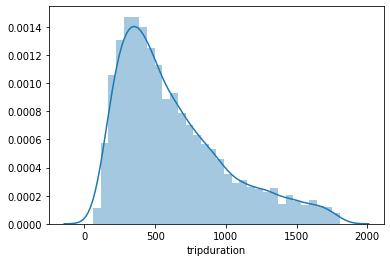

In [361]:
sns.distplot(mb['tripduration'])

- tripduration主要分布在61-1800米之间
- 大部分人的骑行距离在500米以内


#### dayofweek的分布

In [362]:
mb['dayofweek'].value_counts()

1    1062
2    1033
0     975
3     972
4     842
5     517
6     452
Name: dayofweek, dtype: int64

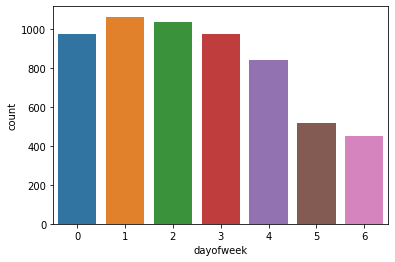

In [363]:
sns.countplot(x='dayofweek', data=mb)

- 明显工作日出行量较大
- 周末出行量变小了

#### hour的分布

In [364]:
mb['hour'].value_counts()

17    781
8     626
16    577
7     433
18    413
15    353
12    311
19    298
14    278
13    273
11    269
9     255
6     226
10    208
20    163
21    106
22     75
5      66
23     53
0      32
1      23
4      19
2      10
3       5
Name: hour, dtype: int64

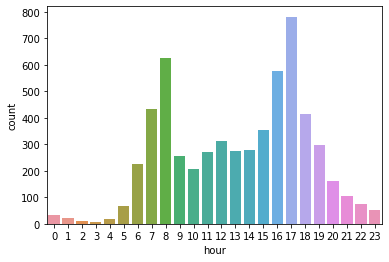

In [365]:
sns.countplot(x='hour',data=mb)

- 明显看到在上下班高峰期（6-9和15-19）的使用量很大
- 夜间使用量慢慢下降
- 白天使用量趋于平稳

#### age的分布

In [366]:
mb['age'].describe()

count    5853.000000
mean       35.683752
std         9.970922
min        17.000000
25%        28.000000
50%        33.000000
75%        41.000000
max        63.000000
Name: age, dtype: float64

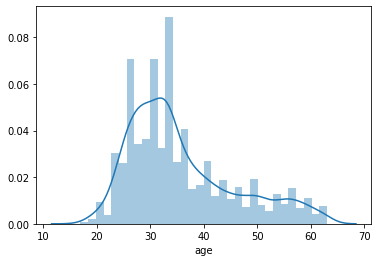

In [367]:
sns.distplot(mb['age'])

- age主要分布在20-62岁之间
- 大部分用户年龄在38岁以下

### 类别变量

#### gender的分布

In [368]:
mb['gender'].value_counts()

Male       4324
Female     1224
Unknown     305
Name: gender, dtype: int64

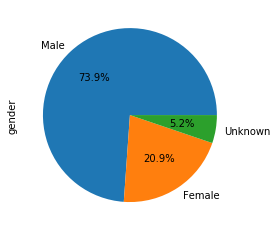

In [369]:
mb['gender'].value_counts().plot(kind='pie', autopct='%1.1f%%')

- 男性用户占了74%
- 女性用户占了21%

#### usertype的分布

In [370]:
mb['usertype'].value_counts()

Subscriber    5423
Customer       430
Name: usertype, dtype: int64

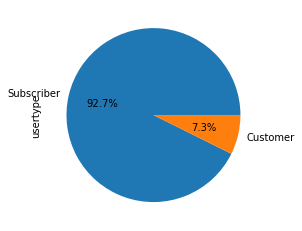

In [371]:
mb['usertype'].value_counts().plot(kind='pie', autopct='%1.1f%%')

- subscriber类型的用户占了92.7%
- customer类型的用户只占了7.3%

## 多变量探索

### 性别和骑行时间的关系

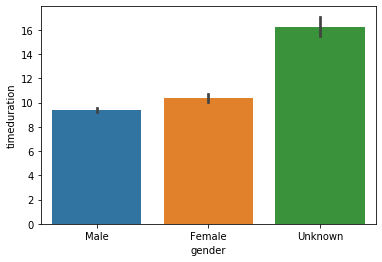

In [372]:
sns.barplot(x='gender', y='timeduration', data=mb)

- 平均来说，Unknown性别的用户的骑行时间最长，然后是女性、男性

### 性别和骑行距离的关系

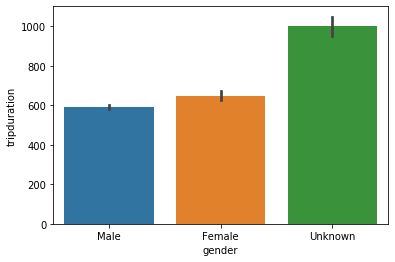

In [373]:
sns.barplot(x='gender', y='tripduration', data=mb)

- 平均来说，Unknown性别的用户的骑行距离最长，其次是女性、男性

### 用户类型和骑行时间的关系

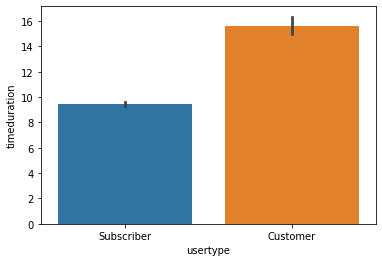

In [374]:
sns.barplot(x='usertype', y='timeduration', data=mb)

- 平均来说，customer用户的骑行时间为16小时，subscriber用户的骑行时间为9.5小时

### 用户类型和骑行距离的关系

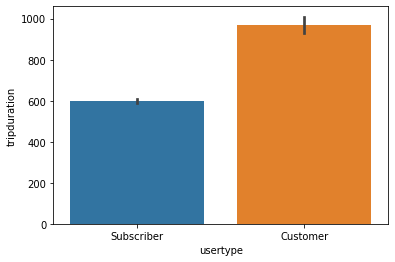

In [375]:
sns.barplot(x='usertype', y='tripduration', data=mb)

- 平均来说，customer用户的平均骑行距离为100米
- subscriber用户的平均骑行距离为600米

### dayofweek、gender和hour的关系

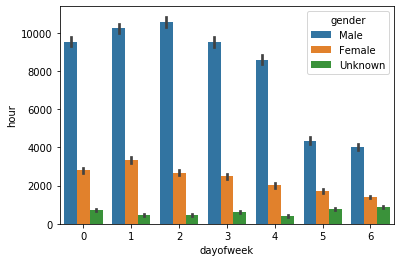

In [376]:
sns.barplot(x='dayofweek', hue='gender',y='hour', data=mb,estimator=sum)

- 男性用户和女性用户在工作日使用较多，而在周末使用量下降
- Unknown用户在周末反而增多

### dayofweek、usertype和hour的关系

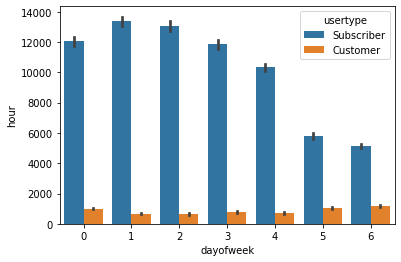

In [377]:
sns.barplot(x='dayofweek', hue='usertype',y='hour', data=mb,estimator=sum)

- subscriber用户在工作日使用量较多，周末使用量下降
- 而customer用户在周末使用量上升

### 骑行时间和骑行距离的关系

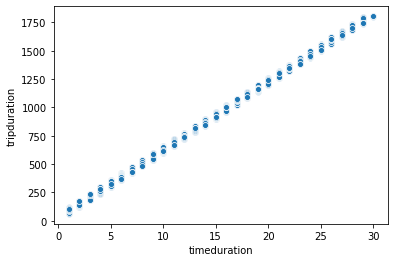

In [378]:
sns.scatterplot(x='timeduration', y='tripduration', data=mb)

- 可以看到，骑行时间和骑行距离是成正比的

# 模型建立

In [379]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [380]:
mb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5853 entries, 439283 to 278179
Data columns (total 9 columns):
timeduration         5853 non-null int64
tripduration         5853 non-null int64
from_station_name    5853 non-null object
to_station_name      5853 non-null object
usertype             5853 non-null object
gender               5853 non-null object
age                  5853 non-null int32
dayofweek            5853 non-null int64
hour                 5853 non-null int64
dtypes: int32(1), int64(4), object(4)
memory usage: 594.4+ KB


In [381]:
# 删除from_station_name和to_station_name
mb = mb.drop(['from_station_name', 'to_station_name'], axis=1)

In [382]:
# 转变哑变量
mb = pd.get_dummies(mb, drop_first=True)

In [383]:
mb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5853 entries, 439283 to 278179
Data columns (total 8 columns):
timeduration           5853 non-null int64
tripduration           5853 non-null int64
age                    5853 non-null int32
dayofweek              5853 non-null int64
hour                   5853 non-null int64
usertype_Subscriber    5853 non-null uint8
gender_Male            5853 non-null uint8
gender_Unknown         5853 non-null uint8
dtypes: int32(1), int64(4), uint8(3)
memory usage: 428.6 KB


In [393]:
# 建立kmeans模型
kmeans_3 = KMeans(3)
model_3 = kmeans_3.fit(mb)

# 模型评估

In [394]:
labels_3 = model_3.predict(mb)

In [395]:
score_3 = silhouette_score(mb,labels_3)
score_3

0.592765519148788

In [396]:
# 使用for循环，寻找最佳分裂数
scores = []
for center in range(2, 6):
    km = KMeans(center)
    model = km.fit(mb)
    label = model.predict(mb)
    scores.append(silhouette_score(mb,label))

Text(0.5, 1.0, 'score vs. n_cluster')

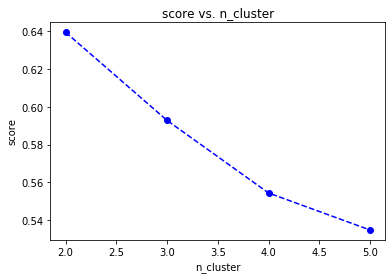

In [399]:
plt.plot(range(2,6), scores, linestyle='--', marker='o', color='b')
plt.xlabel('n_cluster')
plt.ylabel('score')
plt.title('score vs. n_cluster')

- 模型在群数为2时的效果最好

# 业务分析

In [400]:
kmeans_2 = KMeans(2)
model_2 = kmeans_2.fit(mb)
label_2 = model_2.predict(mb)
mb['labels'] = label_2

In [404]:
mb.groupby(['labels'])['age'].describe()

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
0,4243.0,35.623615,10.132478,17.0,28.0,33.0,41.0,63.0
1,1610.0,35.842236,9.533296,18.0,29.0,33.0,40.0,63.0


- 两个群集的年龄差距不大

In [405]:
mb.groupby(['labels'])['timeduration'].describe()

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
0,4243.0,6.66321,2.921483,1.0,4.0,6.0,9.0,13.0
1,1610.0,18.55528,4.593452,13.0,15.0,18.0,22.0,30.0


- 群0的骑行时间长度范围在1-13之间
- 群1的骑行时间长度范围在13-30之间

In [406]:
mb.groupby(['labels'])['tripduration'].describe()

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
0,4243.0,429.207872,174.843564,61.0,290.0,412.0,565.0,786.0
1,1610.0,1142.909317,275.197343,787.0,904.0,1083.0,1340.0,1805.0


- 群0的骑行距离范围在61-786之间
- 群1的骑行距离范围在787-1805之间

In [407]:
mb.groupby(['labels'])['dayofweek'].describe()

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
0,4243.0,2.461230,1.793065,0.0,1.0,2.0,4.0,6.0
1,1610.0,2.649689,1.925658,0.0,1.0,2.0,4.0,6.0


- 两个群集的dayofweek差别不大

In [408]:
mb.groupby(['labels'])['hour'].describe()

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
0,4243.0,13.158850,4.795314,0.0,8.0,14.0,17.0,23.0
1,1610.0,13.532919,4.617956,0.0,9.0,15.0,17.0,23.0


- 两个群集的hour差别不大

In [414]:
# 把聚类中心结果导出到csv文件
centers = pd.DataFrame(model_2.cluster_centers_)
centers.to_csv('centers_2.csv')

In [418]:
%%html
<img src='center_2.png'>

- 由于timeduration和tripduration是线性相关的，因此群0和群1按照从小到大对数据分成了2半
- 群0的骑行时间长度范围在1-13之间，骑行距离范围在61-786之间
- 群1的骑行时间长度范围在13-30之间，骑行距离范围在787-1805之间